In [1]:
import pandas as pd
import numpy as np

import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Data about user sessions. 

Link to the file:

https://drive.google.com/file/d/1z3kg5V_lb57yursFzcE1QgORTo1q1rTG/view?usp=share_link 

One line in the file contains factors calculated for one daily user session (one line = one user). In the line, the factors are separated by tab marks, the physical meaning of the factors is not disclosed. It is known that both sessions of living people and robots are present in the file. It is also known that work sessions differ from live user sessions in that they have certain patterns in behavior (for our case, in the values of factors). 

It is necessary to divide the sessions into two parts - robot and human.


In [2]:
# Reading file

df = pd.read_csv('task2_1.txt', delimiter = "\t", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,00011c50142ae5fc38d843b255ce0479,2,0,0,1399228024,0,98,100,0,0,...,0,-,-,-,-,-,-,-,-,0
1,00035629cd6ca3d78e12e7f42212e122,-,0,-,1365397626,392,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
2,0008ade24d499170c2cacf17f1c97802,-,0,-,1399309402,0,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
3,0009ab6f9c703b0c7e293d34d20496cc,-,0,-,1399045106,2,-,-,0,0,...,-,-,-,-,-,-,-,-,-,-
4,000a5007e8cd86b63daae112245f3a4c,1,0,0,1377952226,246,-,35,0,0,...,0,-,-,-,-,-,-,-,-,-


In [3]:
list_old = df.columns.tolist()
list_new = []

def col_names(df, list_old: list, list_new: list, number: int):
    """Changes names of columns"""
    for i in range(number):
        name_col = 'Column' + '_' + str(i)
        list_new.append(name_col)
    return df.rename(columns=dict(zip(list_old, list_new)), inplace=True)

col_names(df, list_old, list_new, number=188)

In [5]:
df.shape

(49958, 188)

In [6]:
#df.set_index('Column_0')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49958 entries, 0 to 49957
Columns: 188 entries, Column_0 to Column_187
dtypes: int64(43), object(145)
memory usage: 71.7+ MB


## Preprocessing 

In [7]:
def df_numeric(dataframe):
    """Changes non-numeric symbols '-' to NaN and returns dataframe"""
    for column in dataframe.select_dtypes(include=[object]).columns.tolist()[1:]:
        dataframe[column] = pd.to_numeric(dataframe[column].str.replace('\D', ''), 
                                          downcast='integer', errors='coerce')
    
    return dataframe

df_numeric(dataframe=df)

,Column_0,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,...,Column_178,Column_179,Column_180,Column_181,Column_182,Column_183,Column_184,Column_185,Column_186,Column_187
0,00011c50142ae5fc38d843b255ce0479,2.0,0,0.0,1399228024,0,98.0,100.0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,00035629cd6ca3d78e12e7f42212e122,NaN,0,NaN,1365397626,392,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0008ade24d499170c2cacf17f1c97802,NaN,0,NaN,1399309402,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009ab6f9c703b0c7e293d34d20496cc,NaN,0,NaN,1399045106,2,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000a5007e8cd86b63daae112245f3a4c,1.0,0,0.0,1377952226,246,NaN,35.0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49953,fff78c3b2c90313273ff10038c844ebc,NaN,0,NaN,1399240644,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49954,fff8b88d21edbdddca91b58f0b13b605,1.0,0,0.0,1378016729,245,NaN,33.0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49955,fffd4c934b8e18f101f463da6f9c0971,NaN,0,NaN,1399236499,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49956,fffe4ced5415dad9ecfa2fa73857ff48,1.0,0,0.0,1382367599,195,NaN,50.0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df.fillna(0)

def df_int(dataframe):
    """Changes all numeric symbols to int and del columns with sum=0 and returns dataframe"""
    for column in dataframe.columns.tolist()[1:]:
        dataframe[column] = dataframe[column].astype(int)
        
        if sum(dataframe[column]) == 0:
            del dataframe[column]
    
    return dataframe

df_int(dataframe=df)

,Column_0,Column_1,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_11,Column_12,...,Column_178,Column_179,Column_180,Column_181,Column_182,Column_183,Column_184,Column_185,Column_186,Column_187
0,00011c50142ae5fc38d843b255ce0479,2,0,1399228024,0,98,100,0,1399234128,6104,...,0,0,0,0,0,0,0,0,0,0
1,00035629cd6ca3d78e12e7f42212e122,0,0,1365397626,392,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0008ade24d499170c2cacf17f1c97802,0,0,1399309402,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0009ab6f9c703b0c7e293d34d20496cc,0,0,1399045106,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000a5007e8cd86b63daae112245f3a4c,1,0,1377952226,246,0,35,0,1399256676,86401,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49953,fff78c3b2c90313273ff10038c844ebc,0,0,1399240644,0,0,0,0,1399240644,0,...,0,0,0,0,0,0,0,0,0,0
49954,fff8b88d21edbdddca91b58f0b13b605,1,0,1378016729,245,0,33,0,1399260128,86401,...,0,0,0,0,0,0,0,0,0,0
49955,fffd4c934b8e18f101f463da6f9c0971,0,0,1399236499,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49956,fffe4ced5415dad9ecfa2fa73857ff48,1,0,1382367599,195,0,50,0,1399257507,86401,...,0,0,0,0,0,0,0,0,0,0


## Clustering 

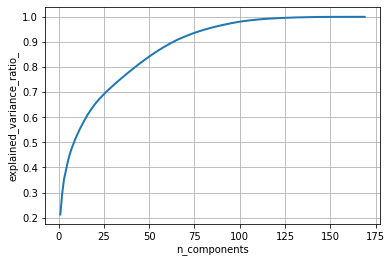

In [9]:
X = df.iloc[:, 1:]
X_scal = StandardScaler().fit_transform(X)

# Explained variance with PCA 
pca = PCA().fit(X_scal)
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_');

In [10]:
# Dimension reduction with TruncatedSVD 
# On 50 components, we have explained more than 80% of the variance, but we take 3 components for visual 

X_svd = TruncatedSVD(n_components=3, n_iter=12, random_state=42).fit_transform(X_scal)

In [11]:
# Dimension reduction with T-SNE 
# T-SNE reduces the dimension by trying to keep objects close to each other in the original space
# distant - away from each other (to visualize clusters)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scal)

In [12]:
# DBSCAN with SVD 

dbscan_svd = cluster.DBSCAN(eps=1.2, min_samples=17).fit(X_svd)
model_dbscan_svd = dbscan_svd.labels_
model_dbscan_svd

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [13]:
# DBSCAN with TSNE works awful... 

dbscan_tsne = cluster.DBSCAN(eps=1.2, min_samples=17).fit(X_tsne)
model_dbscan_tsne = dbscan_tsne.labels_
model_dbscan_tsne

array([  0,   1,  48, ..., 162,  -1, 178], dtype=int64)

In [14]:
# KMEANS with SVD 

kmeans_svd = cluster.KMeans(n_clusters=2, random_state=42).fit(X_svd)
model_kmeans_svd = kmeans_svd.labels_
model_kmeans_svd

array([0, 1, 1, ..., 1, 0, 0])

In [15]:
# KMEANS with TSNE

kmeans_tsne = cluster.KMeans(n_clusters=2, random_state=42).fit(X_tsne)
model_kmeans_tsne = kmeans_tsne.labels_
model_kmeans_tsne

array([0, 1, 1, ..., 1, 0, 0])

In [16]:
np.unique(model_dbscan_svd)

array([-1,  0,  1,  2,  3], dtype=int64)

In [17]:
np.unique(model_kmeans_svd)

array([0, 1])

In [18]:
np.unique(model_kmeans_tsne)

array([0, 1])

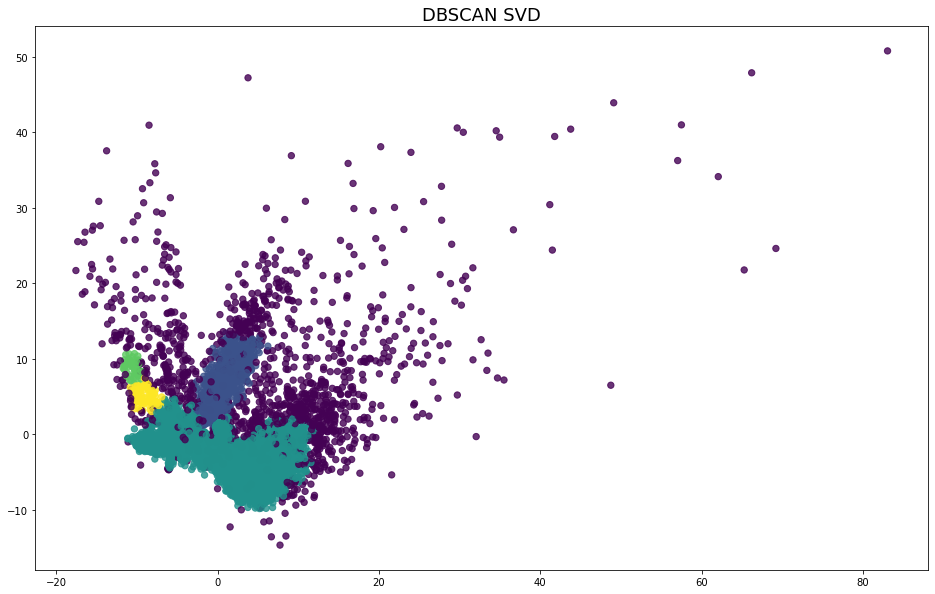

In [19]:
# Visualization DBSCAN SVD (5 clusters)

plt.figure(figsize=(16, 10))
plt.title('DBSCAN SVD', fontsize=18)
plt.scatter(X_svd[:, 1], X_svd[:, 2], s=40, 
            c=model_dbscan_svd, marker='o', 
            alpha=0.8, label='data')
plt.show()

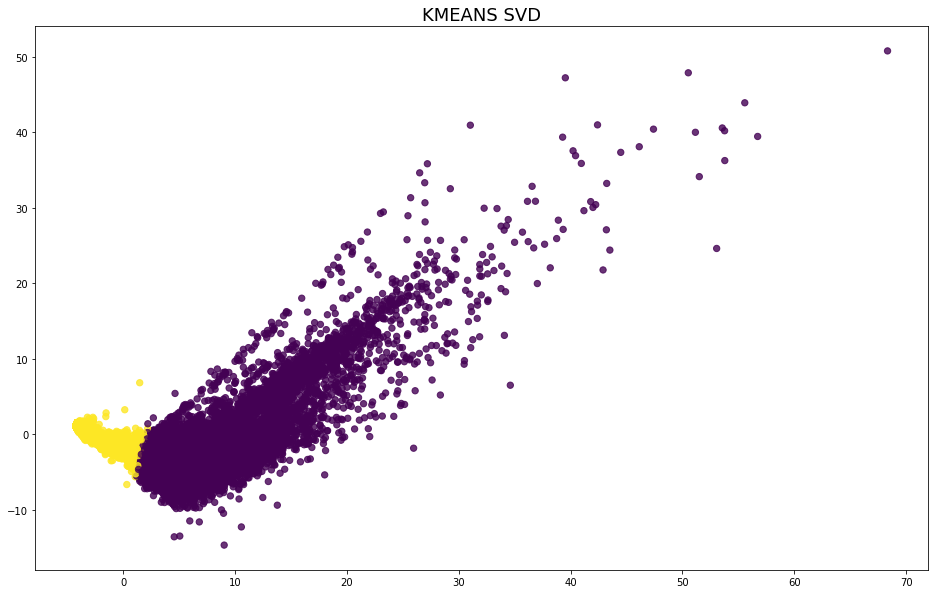

In [20]:
# Visualization KMEANS SVD (2 clusters)

plt.figure(figsize=(16, 10))
plt.title('KMEANS SVD', fontsize=18)
plt.scatter(X_svd[:, 0], X_svd[:, 2], s=40, 
            c=model_kmeans_svd, marker='o', 
            alpha=0.8, label='data')
plt.show()

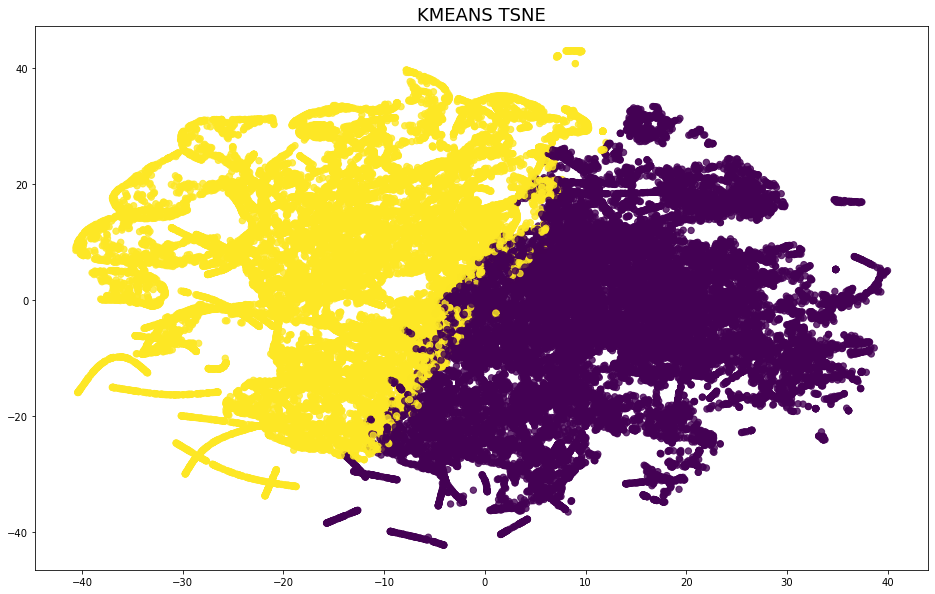

In [26]:
# Visualization KMEANS TSNE (2 clusters)

plt.figure(figsize=(16, 10))
plt.title('KMEANS TSNE', fontsize=18)
plt.scatter(X_tsne[:, 0], X_tsne[:, 2], s=40, 
            c=model_kmeans_tsne, marker='o', 
            alpha=0.8, label='data')
plt.show()

In [27]:
# let's add distribution by clusters to dataframe 

df['Group_kmeans_svd'] = pd.Series(model_kmeans_svd, index=df.index)
df['Group_kmeans_tsne'] = pd.Series(model_kmeans_tsne, index=df.index)

In [28]:
df.Group_kmeans_svd.value_counts(normalize=True)

1    0.67829
0    0.32171
Name: Group_kmeans_svd, dtype: float64

In [29]:
df.Group_kmeans_tsne.value_counts(normalize=True)

0    0.52346
1    0.47654
Name: Group_kmeans_tsne, dtype: float64

In [30]:
# Rename column with session_id and save 

df = df.rename({'Column_0': 'Session_id'}, axis=1) 
submission = df[['Session_id', 'Group_kmeans_svd']]
submission['Group_kmeans_svd'] = submission['Group_kmeans_svd'].map(
    lambda x: 'Robot' if x == 1 else 'Human'
)

submission.head()

submission.to_csv('submission.csv', index=False)

,Session_id,Group_kmeans_svd
0,00011c50142ae5fc38d843b255ce0479,Human
1,00035629cd6ca3d78e12e7f42212e122,Robot
2,0008ade24d499170c2cacf17f1c97802,Robot
3,0009ab6f9c703b0c7e293d34d20496cc,Robot
4,000a5007e8cd86b63daae112245f3a4c,Human


## Conclusion 

Based on the study of the available data, it should be noted:

- To divide the sessions into 2 groups, clustering was chosen as the most appropriate way to solve this task. 

- Taking into account a large number of features, 2 approaches of dimensionality reduction were applied - SVD decomposition and T-SNE, independently of each other with preliminary data standardization. 

- DBSCAN and Kmeans were used among clustering techniques. Kmeans performed better. 

- When distributing data into groups based on Kmeans with T-SNE decomposition, the ratio turned out to be as follows: group 0 - 47.7%, group 1 - 53.3%. That is, almost 50/50, which may not be exactly like the truth, given the visualization. 

- When distributing data into groups based on Kmeans with SVD decomposition, the ratio turned out to be as follows: group 0 - 32.2%, group 1 - 67.8%. Based on the task condition and the visualization done, group 1 may well be a group related to sessions from robots, and group 0 - to sessions from humans. 


P.S.: Among other acceptable ways to solve the task under consideration, an approach based on genetic algorithms can be distinguished.
